# Assignment 1: Balancing a Pole on a Cart



------------
### Contributions
- Teo Hong Guan Brian: All contributions ÷ 3
- Ferguson Chiew: All contributions ÷ 3
- Toh Si En Ernneth: All contributions ÷ 3
------------

### Import Required Dependencies

In [1]:
import json
import random
import time
from collections import deque

import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import keras
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import io
import base64
import glob
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  # Search for all files with .mp4 extension in the 'video' directory
  mp4list = glob.glob('video/*.mp4')

  # Check if any .mp4 files are found
  if len(mp4list) > 0:

    mp4 = mp4list[0] # Select the first .mp4 file found
    video = io.open(mp4, 'r+b').read() # Read the contents of the selected .mp4 file in binary mode
    encoded = base64.b64encode(video) # Encode the binary video data into base64 format

    # Display the video using HTML5 video tag
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  
  else: 
    # If no .mp4 files are found, print a message
    print("Could not find video")

### Set Up Test Environment

In [2]:
env = gym.make("CartPole-v1")
print(env.action_space)
print("\n")
print(env.observation_space)
print("\n")
observation = env.reset()
print("Initial observations:", observation)

Discrete(2)


Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Initial observations: (array([ 0.00270954,  0.02126144,  0.01473464, -0.0077135 ], dtype=float32), {})


## Task 1: Developing of a RL agent

#### Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook.

In [3]:
class DQNAgent:
    
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # Initialize Replay Buffer as python deque
        self.replay_buffer = deque(maxlen=100000)
        
        # Set algorithm hyperparameters
        self.gamma = 0.99
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.98
        self.learning_rate = 0.001
        self.update_rate = 10
        
        # Create both Main and Target Networks
        self.main_network = self.create_nn()
        self.target_network = self.create_nn()
        
        # Initialize Target Network with Main Network's weights
        self.update_target_network()

    def create_nn(self):
        # Create a neural network model
        model = Sequential()

        # Adding layers to the model
        model.add(Dense(64, activation='relu', input_dim=self.state_size))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))

        return model
    
    def update_target_network(self):
        # Method to set the Main NN's weights on the Target NN
        self.target_network.set_weights(self.main_network.get_weights())

    def save_experience(self, state, action, reward, next_state, terminal):
        # Save the given experience as a (s, a, r, s', terminal) tuple
        self.replay_buffer.append((state, action, reward, next_state, terminal))

    def sample_experience_batch(self, batch_size):
        # Sample {batchsize} experiences from the ReplayBuffer
        exp_batch = random.sample(self.replay_buffer, batch_size)

        # Create an array with the {batchsize} elements for s, a, r, s' and terminal information
        state_batch = np.array([batch[0] for batch in exp_batch]).reshape(batch_size, self.state_size)
        action_batch = np.array([batch[1] for batch in exp_batch])
        reward_batch = [batch[2] for batch in exp_batch]
        next_state_batch = np.array([batch[3] for batch in exp_batch]).reshape(batch_size, self.state_size)
        terminal_batch = [batch[4] for batch in exp_batch]

        # Return a tuple, where each item corresponds to each array/batch created above
        return state_batch, action_batch, reward_batch, next_state_batch, terminal_batch

    def pick_epsilon_greedy_action(self, state):
        # Pick random action with probability ε
        if random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.action_size)

        # Pick action with highest Q-Value (item with highest value for Main NN's output)
        state = state.reshape((1, self.state_size))
        q_values = self.main_network.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def train(self, batch_size):
        # Sample a batch of experiences
        state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = self.sample_experience_batch(batch_size)

        # Get the actions with highest Q-Value for the batch of next states
        next_q = self.target_network.predict(next_state_batch, verbose=0)
        max_next_q = np.amax(next_q, axis=1)
        # Get the Q-values of each state in the batch of states
        q_values = self.main_network.predict(state_batch, verbose=0)

        # Update the Q-Value corresponding to the current action with the Target Value
        for i in range(batch_size):
            q_values[i][action_batch[i]] = reward_batch[i] if terminal_batch[i] else reward_batch[i] + self.gamma * max_next_q[i]

        # Fit the network
        self.main_network.fit(state_batch, q_values, verbose=0)

# This DQN_Agent class is referred from external sources.

In [4]:
# Initialize CartPole environment
env = gym.make('CartPole-v1')

# Define state and action size
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [5]:
# Define the number of episodes (complete runs through the environment) and timesteps (maximum steps per episode)
num_episodes = 200
num_timesteps = 500

# Define batch size for experience replay
batch_size = 64

In [6]:
# Initialize a Deep Q-Network (DQN) agent with given state and action sizes
dqn_agent = DQNAgent(state_size, action_size)

### Implementation of training loop for the DQN agent

In [8]:
rewards, epsilon_values = list(), list() # Lists to keep logs of rewards and apsilon values, for plotting later
time_step = 0 # Initalize timestep counter

for ep in range(num_episodes):
    tot_reward = 0 # Initialize total reward for the episode
    state, _ = env.reset() # Reset the environment and get initial state
    
    print(f'\nTraining on EPISODE {ep+1} with epsilon {dqn_agent.epsilon}')
    start = time.time() # Record start time of the episode
    
    for t in range(num_timesteps):
        time_step += 1 # Increment timestep counter after every iteration
        
        # Update Target Network every {dqn_agent.update_rate} timesteps
        if time_step % dqn_agent.update_rate == 0:
            dqn_agent.update_target_network()
            
        action = dqn_agent.pick_epsilon_greedy_action(state) # Select action with ε-greedy policy
        next_state, reward, terminal, _, _ = env.step(action) # Perform action on environment
        dqn_agent.save_experience(state, action, reward, next_state, terminal) # Save experience in ReplayBuffer

        state = next_state # Update current state
        tot_reward += reward # Accumulate reward for the episode

        if terminal:
            print('Episode: ', ep+1, ' terminated with Reward ', tot_reward)
            break

        # Train the Main Network when ReplayBuffer has enough experiences to fill a batch
        if len(dqn_agent.replay_buffer) > batch_size:
            dqn_agent.train(batch_size)

    rewards.append(tot_reward) # Append total reward for the episode to rewards list
    epsilon_values.append(dqn_agent.epsilon) # Append current epsilon value to epsilon_values list
    
    # Everytime an episode is finished, update Epsilon value to a lower value
    if dqn_agent.epsilon > dqn_agent.epsilon_min:
        dqn_agent.epsilon *= dqn_agent.epsilon_decay
        
    # Print information about the Episode performed
    elapsed = time.time() - start
    print(f'Time elapsed during EPISODE {ep+1}: {elapsed} seconds = {round(elapsed/60, 3)} minutes')

    # If the agent got a reward >499 in each of the last 10 episodes, the training is terminated
    if sum(rewards[-10:]) > 499:
        print('Training stopped because agent has performed a perfect episode in the last 10 episodes')
        break
        


Training on EPISODE 1 with epsilon 1
Episode:  1  terminated with Reward  27.0
Time elapsed during EPISODE 1: 0.006233930587768555 seconds = 0.0 minutes

Training on EPISODE 2 with epsilon 0.98
Episode:  2  terminated with Reward  13.0
Time elapsed during EPISODE 2: 0.005594015121459961 seconds = 0.0 minutes

Training on EPISODE 3 with epsilon 0.9603999999999999


c:\Users\brian\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode:  3  terminated with Reward  15.0
Time elapsed during EPISODE 3: 0.23233699798583984 seconds = 0.004 minutes

Training on EPISODE 4 with epsilon 0.9411919999999999
Episode:  4  terminated with Reward  10.0
Time elapsed during EPISODE 4: 0.042655229568481445 seconds = 0.001 minutes

Training on EPISODE 5 with epsilon 0.9223681599999999
Episode:  5  terminated with Reward  23.0
Time elapsed during EPISODE 5: 3.2499642372131348 seconds = 0.054 minutes

Training on EPISODE 6 with epsilon 0.9039207967999998
Episode:  6  terminated with Reward  11.0
Time elapsed during EPISODE 6: 1.138350486755371 seconds = 0.019 minutes

Training on EPISODE 7 with epsilon 0.8858423808639998
Episode:  7  terminated with Reward  20.0
Time elapsed during EPISODE 7: 2.2478344440460205 seconds = 0.037 minutes

Training on EPISODE 8 with epsilon 0.8681255332467198
Episode:  8  terminated with Reward  15.0
Time elapsed during EPISODE 8: 1.6570408344268799 seconds = 0.028 minutes

Training on EPISODE 9 with

### ** Only run this code segment the first time to save the trained model **
--------------

In [9]:
dqn_agent.main_network.save('trained_agent.h5')
print("Trained agent saved in 'trained_agent.h5'")

Trained agent saved in 'trained_agent.h5'


c:\Users\brian\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


----------

In [9]:
def select_trained_agent_action(state, trained_model):
    q_values = trained_model.predict(state, verbose=0)
    return np.argmax(q_values[0]) # Return the index of the action with the highest Q-value

def load_pretrained_model(path):
    """Load a pretrained model from the path provided as parameter"""
    return keras.models.load_model(path) # Load and return the pretrained model from the specified path

### Running one test episode on the trained model

In [23]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
state, _ = env.reset()
state_size = env.observation_space.shape[0]
total_reward = 0
max_timesteps = 500
terminal = False
trained_agent = load_pretrained_model('trained_agent.h5')

# Execute episode
for t in range(max_timesteps):
    print(f'Running frame {t+1}...', end='\r')
    
    # Reshape the state into the appropriate shape expected by the model
    state = state.reshape((1, state_size))
    # Choose an action based on the current state and the pretrained agent model
    action = select_trained_agent_action(state, trained_agent)
    # Execute the chosen action in the environment and obtain the next state, reward, and terminal flag
    next_state, reward, terminal, _, _ = env.step(action)
    
    # Accumulate the reward and update the current state
    total_reward += reward
    state = next_state
    
    if terminal:
        break
    
env.close() # Close the environment once the episode is finished
    
print(f'Test episode terminated with reward {total_reward}')
print("Chosen action: ", action)

c:\Users\brian\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Test episode terminated with reward 500.0
Chosen action:  0


## Task 2: Demostrate Effectiveness of RL Agent

#### Run for 100 episodes (reset the environment at the beginning of each episode) and plot the cumulative reward against all episodes in Jupyter. Print the average reward over the 100 episodes. The average reward should be larger than 195.

In [11]:
def plot_rewards(rewards):
    # Plot the cumulative reward against the episodes
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward for Each Episode')
    plt.show()

    # Print the average reward over the 100 episodes
    print("Average cumulative reward: ", sum(rewards[:100])/100)

    # Check if the average reward is larger than 195 (task requirement)
    print("Is my agent good enough?", sum(rewards[:100])/100 > 195)

c:\Users\brian\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


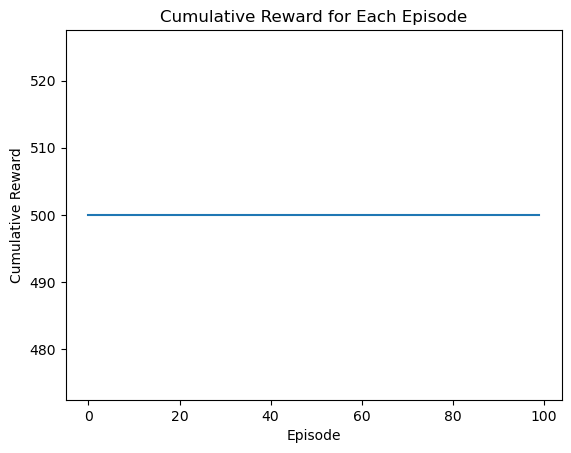

Average cumulative reward:  500.0
Is my agent good enough? True


In [24]:
if __name__ == '__main__':

    env = gym.make('CartPole-v1', render_mode='rgb_array')
    state, _ = env.reset()
    state_size = env.observation_space.shape[0]
    terminal = False
    trained_agent = load_pretrained_model('trained_agent.h5')

    total_rewards = []
    
    num_episodes = 100
    max_timesteps = 500

    # Execute 100 Episodes
    for episode in range(num_episodes):
        state, _ = env.reset() # Reset environment every episode
        total_reward = 0
        
        for t in range(max_timesteps):

    
            state = state.reshape((1, state_size))
            action = select_trained_agent_action(state, trained_agent)
            next_state, reward, terminal, _, _ = env.step(action)
            
            total_reward += reward
            state = next_state
            
            if terminal:
                break

        total_rewards.append(total_reward)
    
    env.close()
        

    plot_rewards(total_rewards)

We have trained the model several times to obtain the optimal graph as shown above. 
- Re-running the code and re-training the model is essential to obtain higher cumulative rewards
- It is also crucial to store the rewards after each training for rewards to improve

## Task 3: Render One Episode Played by the Agent

In [26]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, './video',episode_trigger = lambda episode_number: True)
trained_agent = load_pretrained_model('trained_agent.h5')
state, _ = env.reset()
state_size = env.observation_space.shape[0]
terminal = False
tot_reward = 0
# env.start_video_recorder()

while tot_reward <= 500:
  state = state.reshape((1, state_size))
  action = select_trained_agent_action(state, trained_agent)
  next_state, reward, terminal, _, _ = env.step(action)
  
  tot_reward += reward
  state = next_state
  if terminal: 
    break;    

# env.close_video_recorder()
env.close()
show_video()

c:\Users\brian\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video c:\NTU Y2S2\SC3000 Artificial Intelligence\Lab\SC3000-Assignment\video\rl-video-episode-0.mp4.
Moviepy - Writing video c:\NTU Y2S2\SC3000 Artificial Intelligence\Lab\SC3000-Assignment\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\NTU Y2S2\SC3000 Artificial Intelligence\Lab\SC3000-Assignment\video\rl-video-episode-0.mp4


-------------------

### References:

- Learning about Cart-Pole OpenAI Gym using Q-Learning Algorithm: [Detailed Explanation and Python Implementation of Q-Learning Algorithm in OpenAI Gym (Cart-Pole)](https://youtu.be/KMjQmG5Uzis?si=rmVQwBK-sFSs9GSw) _(Aleksandar Haber - Youtube)_
- Application of DQN and OpenAI Gym: [Using DeepQ Learning and OpenAI Gym train a RL Agent to play Frozen Lake and record the game](https://www.youtube.com/watch?v=F4FKG_esLAQ&ab_channel=DataScienceSolutions) _(Data Science Solutions - Youtube)_
- Understanding the DQN algorithm and its implementation: [Applied Reinforcement Learning IV: Implementation of DQN](https://towardsdatascience.com/applied-reinforcement-learning-iv-implementation-of-dqn-7a9cb2c12f97) _(Javier Martínez Ojeda - TowardsDataScience)_

*Apart from the DQN_Agent class, the rest of the works are edited from our referred sources.